# 2D model: Simulating Reaction-Diffusion Systems


<div class="alert alert-block alert-success">

In this notebook we provide the code which demonstrates how to simulate a reaction-diffusion system. For now we use the [Gray-Scott model](http://www.karlsims.com/rd.html). This example is taken from [Benjamin F. Maier's](https://github.com/benmaier) personal Github repository, supplemented with descriptions taken from [Karl Sims](http://www.karlsims.com/rd.html). Work through this notebook which provides you with a working example of a reaction diffusion system for two species. At the end there are two exercises.
    
 - 1) [Introduction to the theoretical framework](#Introduction)
 - 2) [Choosing initial conditions](#initial_conditions)
 - 3) [Running our first simulation](#initial_simulation)
 - 4) [Experiment1](#Experiment1)
 - 5) [Experiment2](#Experiment2)
 - 6) [Experiment3](#Experiment3)
 
As with our other notebooks, we will provide you with a template for plotting the results. These practicals are designed for you to take outside of class and continue working on them. 

</div>

## 1) Introduction to the theoretical framework <a name="Introduction"></a>

In this notebook we provide the code which demonstrates how to simulate a reaction-diffusion system. For now we use the [Gray-Scott model](http://www.karlsims.com/rd.html). This example is taken from [Benjamin F. Maier's](https://github.com/benmaier) personal Github repository, supplemented with descriptions taken from [Karl Sims](http://www.karlsims.com/rd.html). 

In this model, we model the reaction-diffusion of two chemicals $A$ and $B$ which are distributed across a grid of size $N$. As they diffuse and react, they will move across the 2D space according to their initial conditions and parameters that dictate these interactions.

The Gray-Scott model is described using two partial differential equations

$$
\frac{\partial A}{\partial t} = D_A (\nabla^2 A) - AB^2 + f(1-A) \\
\frac{\partial B}{\partial t} = D_B (\nabla^2 B) - AB^2 + (k+f)B 
$$ 

The discrete, and easier to read, version of these equations are: 

$$
A_{ij}(t+1) = A_{ij}(t) + \Big[D_A (\nabla^2 A)_{ij} - A_{ij}B_{ij}^2 + f(1-A_{ij}) \Big]\times\Delta t\\
B_{ij}(t+1) = B_{ij}(t) + \Big[D_B (\nabla^2 B)_{ij} + A_{ij}B_{ij}^2 - (k+f)B_{ij} \Big]\times\Delta t
$$

The symbol $A_{ij}$ represents the concentration of chemical $A$ at grid coordinates $(i,j)$ (similar for $B$). The following figure taken from [Karl Sims](http://www.karlsims.com/rd.html) illustrates the interactions between $A$ and $B$, which have a "feed" rate f and "death" rate k.

<div>
<img src="../images/greyscott.png" width="700"/>
</div>


First, we need to take care of the discretized Laplacian terms $\nabla^2 A$ and $\nabla^2 B$. The discretized Laplacian of a grid cell $(i,j)$ can be computed by summing over neighboring cells and subtract the value of the original cell with the total weight. One possible implementation is to only recognize direct neighbors of grid difference $\Delta=1$, i.e. at $(i,j-1)$, $(i,j+1)$, $(i-1,j)$, and $(i+1,j)$.

The whole update formula is

$$
(\nabla^2 A)_{ij} = A_{i,j-1} + A_{i,j+1} + A_{i-1,j} + A_{i+1,j} - 4A_{ij}
$$

In the following code blocks we implement functions `discrete_laplacian` and `gray_scott_update` that allow us to update the concentrations of $A$ and $B$. Do not worry if you do not understand everything here. As we discuss in the lkecture videos, in these examples we are exposing you to the raw code behind our simulations. If you were running a pre-compiled executbale you would not see this. We could hide the code blocks, or import these functions from seperate modules. Please feel free to practice that if you like, and ask for help where needed.

In [1]:
%matplotlib inline
import numpy as np
from IPython.display import clear_output, display
import matplotlib.pyplot as plt #as per the above, much easier to write over and over again 
import time

def discrete_laplacian(M):
    """Get the discrete Laplacian of matrix M"""
    L = -4*M
    L += np.roll(M, (0,-1), (0,1)) # right neighbor
    L += np.roll(M, (0,+1), (0,1)) # left neighbor
    L += np.roll(M, (-1,0), (0,1)) # top neighbor
    L += np.roll(M, (+1,0), (0,1)) # bottom neighbor
    
    return L

def gray_scott_update(A, B, DA, DB, f, k, delta_t):
    """
    Updates a concentration configuration according to a Gray-Scott model
    with diffusion coefficients DA and DB, as well as feed rate f and
    kill rate k.
    """
    
    # Let's get the discrete Laplacians first
    LA = discrete_laplacian(A)
    LB = discrete_laplacian(B)
    
    # Now apply the update formula
    diff_A = (DA*LA - A*B**2 + f*(1-A)) * delta_t
    diff_B = (DB*LB + A*B**2 - (k+f)*B) * delta_t
    
    A += diff_A
    B += diff_B
    
    return A, B

## 2) Choosing initial conditions <a name="initial_conditions"></a>

The initial conditions are very important in the Gray-Scott model. If you randomize the initial conditions, thus randomly selecting values for $A$ and $B$ in each cell, it is possible the simulation just dies out. It seems to be a good idea to assume a homogeneous distribution of chemicals with a small disturbance which can then produce some patterns. We can also add a bit of noise. In this case we disturb our scenario with a square in the center of the grid. In the following we initialise the concentration of each chemical between 0-1 in each cell. Thus, in these greyscale images black represents a value of 1, and white 0. Anything in between is visualised as a shade of grey. In the following we initialise our 2D space to be dominated by $A$, where a square cell in the middle has values for $A$ of 0.5 and $B$ as 0.25. 

In [2]:
def get_initial_configuration(N, random_influence=0.2):
    """
    Initialize a concentration configuration. N is the side length
    of the (N x N)-sized grid.
    `random_influence` describes how much noise is added.
    """
    
    # We start with a configuration where on every grid cell 
    # there's a lot of chemical A, so the concentration is high
    A = (1-random_influence) * np.ones((N,N)) + random_influence * np.random.random((N,N))
    
    # Let's assume there's only a bit of B everywhere
    B = random_influence * np.random.random((N,N))
    
    # Now let's add a disturbance in the center
    N2 = N//2
    radius = r = int(N/10.0)
    
    A[N2-r:N2+r, N2-r:N2+r] = 0.50
    B[N2-r:N2+r, N2-r:N2+r] = 0.25
    
    return A, B

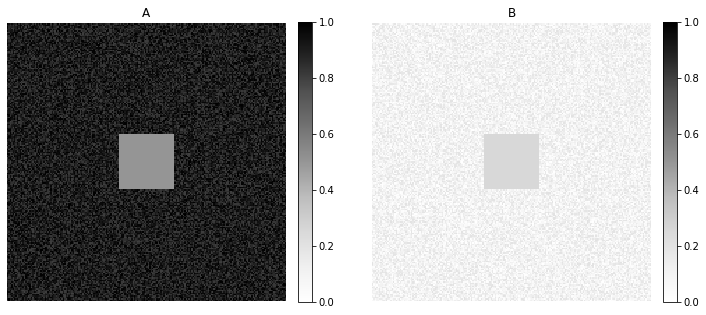

In [3]:
A, B = get_initial_configuration(200)

fig, ax = plt.subplots(1,2,figsize=(12,12))
first=ax[0].imshow(A, cmap='Greys',vmin=0, vmax=1)
second=ax[1].imshow(B, cmap='Greys',vmin=0, vmax=1)
ax[0].set_title('A')
ax[1].set_title('B')
ax[0].axis('off')
ax[1].axis('off')
fig.colorbar(first,ax=ax[0],fraction=0.046, pad=0.04)
fig.colorbar(first,ax=ax[1],fraction=0.046, pad=0.04)
plt.show()


Now we can run a simulation! We should first specific our model parameters as per the following. 

In [4]:
# update in time
delta_t = 1.0

# Diffusion coefficients
DA = 0.16
DB = 0.08

# define feed/kill rates
f = 0.060
k = 0.062

# grid size
N = 200

# simulation steps
N_simulation_steps = 10000

## Running our first simulation  <a name="initial_simulation"></a>

For the simulation we simply update the concentrations for `N_simulation_steps` time steps. After `N_simulation_steps` we can see how different our space looks compared to the previous two figures. In the following code we use a ``` for ``` loop to iterate over `N_simulation_steps` and then plot the final result. Please go ahead and run the following cell.

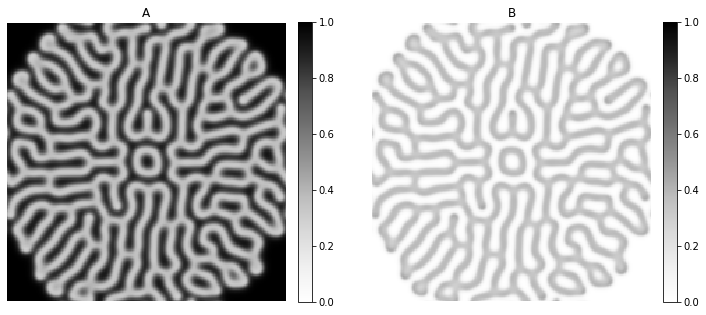

In [5]:
A, B = get_initial_configuration(200)

for t in range(N_simulation_steps):
    A, B = gray_scott_update(A, B, DA, DB, f, k, delta_t)
    
fig, ax = plt.subplots(1,2,figsize=(12,12))
ax[0].imshow(A, cmap='Greys',vmin=0, vmax=1)
ax[1].imshow(B, cmap='Greys',vmin=0, vmax=1)
ax[0].set_title('A')
ax[1].set_title('B')
ax[0].axis('off')
ax[1].axis('off')
fig.colorbar(first,ax=ax[0],fraction=0.046, pad=0.04)
fig.colorbar(first,ax=ax[1],fraction=0.046, pad=0.04)
plt.show()

<div class="alert alert-block alert-success">
<b> Experiment 1 - Evaluating the feed rate needed to maintain a two component system </b> <a name="Experiment1"></a>

You will find below there is a code block waiting for values to be set. If you change the values of DA, DB, and k to 0.14, 0.06, and 0.065 respectively, at what value for the feed rate f does the total concentration of B at the end of the simulation reach zero? Given the theoretical nature of the model, why is this the case? Do you see any distinct changes in the patterns emerging as you cycle through different values? First you will need to fill in the code box, and also remember you will need to run the simulation as we have done before. Following this you will find another code block with the code:

```python
# We can check the values for both A and B
print("Total amount of A = ", np.sum(A))
print("Total amount of A = ", np.sum(B))
```
If you run this cell, you the final concentrations of both A and B will be printed to the screen.

</div>

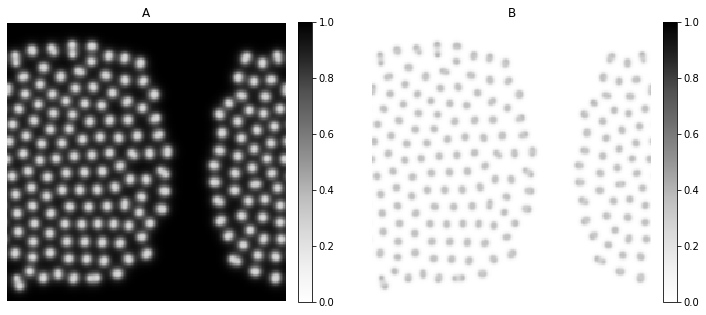

In [6]:
# update in time
delta_t = 1.0

# Diffusion coefficients
DA = 0.14
DB = 0.06

# define feed/kill rates
f = 0.025
k = 0.065

# grid size
N = 200

# Please add code below that initialises the space and runs the simulation.
A, B = get_initial_configuration(200)

for t in range(N_simulation_steps):
    A, B = gray_scott_update(A, B, DA, DB, f, k, delta_t)
    
fig, ax = plt.subplots(1,2,figsize=(12,12))
ax[0].imshow(A, cmap='Greys',vmin=0, vmax=1)
ax[1].imshow(B, cmap='Greys',vmin=0, vmax=1)
ax[0].set_title('A')
ax[1].set_title('B')
ax[0].axis('off')
ax[1].axis('off')
fig.colorbar(first,ax=ax[0],fraction=0.046, pad=0.04)
fig.colorbar(first,ax=ax[1],fraction=0.046, pad=0.04)
plt.show()

In [7]:
# We can check the values for both A and B
print("Total amount of A = ", np.sum(A))
print("Total amount of A = ", np.sum(B))

Total amount of A =  32388.950123645307
Total amount of A =  2124.618364737274


<div class="alert alert-block alert-success">
<b> Experiment 2 - Changing the feed rate as a function of distance from the centre </b> <a name="Experiment2"></a>

So far we have been assuming our feed rate is a constant parameter across the entire space. In the code box below, we can initialise a 2D array for our feed rate f and change its value as we move across our 2D space. This is create a 2D array of f values that increase as we move away from the centre. Recall in the previous experiment we found that we can sustain a 2 component system with specific values of f. In the figures displayed below, we see output from these new simulations when f is either 0.3 or 0.6. They are distinctly different. Can you reproduce these plots and which one corresponds to each value? How else might we introduce a spatial variability?
    
<div>
<img src="../../images/grey_scott_fvaries_example_03.png" width="500"/>
<img src="../.../images/grey_scott_fvaries_example_06.png" width="500"/>

</div>

</div>

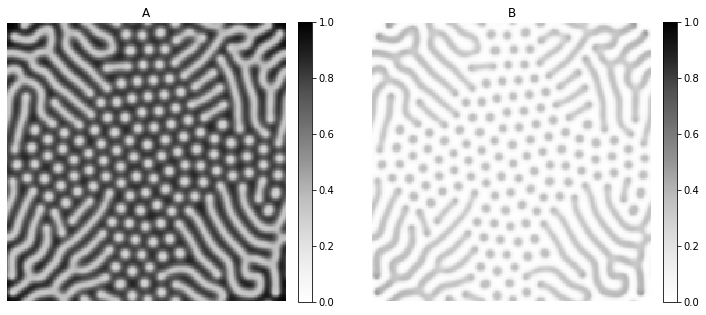

In [8]:
# Create a 2D array of f values that increasesd as we move away from the centre.
x_values = np.linspace(-50.0, 50.0, num=200)
y_values = np.linspace(-50.0, 50.0, num=200)
z_values = np.zeros((200,200))
x_index=0
for x in x_values:
    y_index=0
    for y in y_values:
        z_values[x_index,y_index] = (np.exp(np.abs(x/50)*np.abs(y/50)))
        y_index+=1
    x_index+=1

# Diffusion coefficients
DA = 0.16
DB = 0.08

# define feed/kill rates
f = 0.030
k = 0.062
f_values = z_values*f
    
# Please insert the code required to run a simulation now using the variable 'f_values'

A, B = get_initial_configuration(200)

for t in range(N_simulation_steps):
    A, B = gray_scott_update(A, B, DA, DB, f_values, k, delta_t)
    
fig, ax = plt.subplots(1,2,figsize=(12,12))
ax[0].imshow(A, cmap='Greys',vmin=0, vmax=1)
ax[1].imshow(B, cmap='Greys',vmin=0, vmax=1)
ax[0].set_title('A')
ax[1].set_title('B')
ax[0].axis('off')
ax[1].axis('off')
fig.colorbar(first,ax=ax[0],fraction=0.046, pad=0.04)
fig.colorbar(first,ax=ax[1],fraction=0.046, pad=0.04)
plt.show()

<div class="alert alert-block alert-success">
<b> Experiment 3 - Animating a simulation </b> <a name="Experiment3"></a>

So far we have analysed the initial and end points of our simulation. Quite often when we observe a process we want to observe any changes in patterns as a function of time. In this exercise we provide you with some code for animating the distribution of component A during the simulation. Run the animation with the very first set of parameters we used and then with f varying as a function of distance from the centre. You will need to change one line of code in this code box to look like one of the following code listings:


```python
A_new, B_new = gray_scott_update(A, B, DA, DB, f, k, delta_t)
```

```python
A_new, B_new = gray_scott_update(A, B, DA, DB, f_values, k, delta_t)
```

If you remove the square at the centre, does the simulation change?

</div>


In [9]:
# update in time
delta_t = 1.0

# Diffusion coefficients
DA = 0.16
DB = 0.08

# define feed/kill rates
f = 0.060
k = 0.062

# grid size
N = 200

N_simulation_steps = 1000

delta_t = 1.0

# intialize the figures
A, B = get_initial_configuration(200)

fig, ax = plt.subplots(figsize=(12,12))
plt.imshow(A, cmap='Greys',vmin=0, vmax=1)
plt.colorbar(fraction=0.046, pad=0.04)
plt.show()

# Let us also store the total concentration of A and B as a function of time for an extra 
# plot after this simulation,

A_conc_list=[]
B_conc_list=[]
time_list=[]

for i in range(2000):
    time_list.append(i)
    plt.rcParams["figure.figsize"] = (12, 12);
    #display(plt.gcf());
    clear_output(wait=True)
    A_new, B_new = gray_scott_update(A, B, DA, DB, f_values, k, delta_t)
    A_conc_list.append(np.sum(A_new))
    B_conc_list.append(np.sum(B_new))
    A, B = A_new, B_new
    plt.imshow(A, cmap='Greys',vmin=0, vmax=1)
    plt.colorbar(fraction=0.046, pad=0.04)
    plt.show();
    time.sleep(0.05);


KeyboardInterrupt: 